# Exercises on data clustering and local PCA

## Exercise Extra: 

The goal of this exercise is to explore K-Means and VQPCA clustering of a combustion dataset.

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%matplotlib inline

In this exercise, we use a combustion dataset which represents combustion of hydrogen in air.

Below, we load the dataset, $\mathbf{X}$, composed of 9 variables (columns):

$$
\begin{gather}
\mathbf{X} = 
\begin{bmatrix}
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
T & Y_{H} & Y_{H_2} & Y_{O} & Y_{OH} & Y_{H_2O} & Y_{O_2} & Y_{HO_2} & Y_{H_2O_2} \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
\end{bmatrix}
\end{gather}
$$

The first variable in the dataset is temperature, $T$, and the remaining variables are mass fractions, $Y$, of different chemical species.

The dataset has 13,650 observations (rows).

In [2]:
X = pd.read_csv('H2-air-X.csv', sep = ',', header=None).to_numpy()
X = X[:,0:-3]

In [3]:
X.shape

(13650, 9)

We also load names for all of the variables in $\mathbf{X}$. 

In [4]:
X_names = pd.read_csv('H2-air-X-names.csv', sep = ',', header=None).to_numpy().ravel()
X_names = X_names[0:-3]

In [5]:
X_names

array(['T', 'H', 'H2', 'O', 'OH', 'H2O', 'O2', 'HO2', 'H2O2'],
      dtype=object)

We also load two additional quantities that will be helpful.

The first one is called *mixture fraction*, it represents the local stoichiometry of the flame at every observation in the dataset:

In [6]:
mixture_fraction = pd.read_csv('H2-air-mixture-fraction.csv', sep = ',', header=None).to_numpy()

In [7]:
mixture_fraction.shape

(13650, 1)

The second one is called the *heat release rate*, it's a measurement of the amount of heat released in the combustion process corresponding to every observation in the dataset:

In [8]:
heat_release_rate = pd.read_csv('H2-air-heat-release-rate.csv', sep = ',', header=None).to_numpy()

In [9]:
heat_release_rate.shape

(13650, 1)

***

## Clustering the dataset with K-Means

We are going to find clusters in the dataset using K-Means clustering technique. The documentation of the K-Means algorithm implementation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

First, we need to preprocess the dataset. Center and scale the dataset $\mathbf{X}$ using Auto (standard) scaling in a similar way to what we've done in the previous exercise:

In [10]:
c = np.mean(X, axis=0)
d = np.std( X, axis=0)

X_std = (X - c)/d

Perform clustering of the centered and scaled dataset $\mathbf{X}$ into 4 clusters:

In [11]:
# Complete the K-Means clustering steps:

kmeans_X     = KMeans(n_clusters=4, init='random', n_init='auto', random_state=400).fit(X_std)
idx_kmeans_X = kmeans_X.labels_

Visualize the result of clustering in the mixture fraction and temperature space:

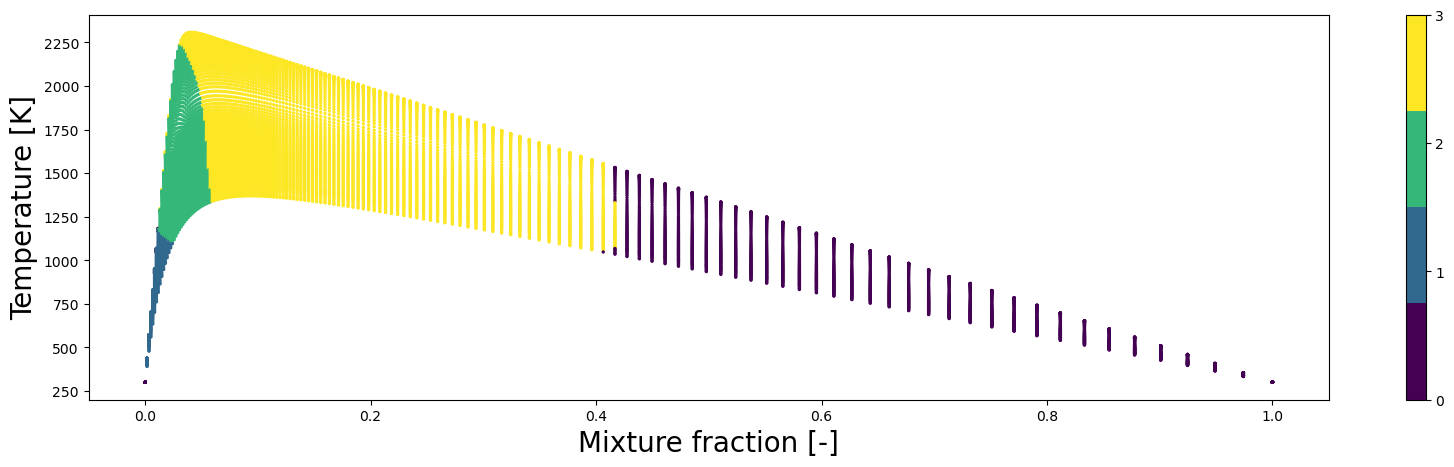

In [12]:
fig = plt.figure(figsize=(20,5))

# Create a scatter plot of the clustering solution: Temperature Vs Mixture Fraction

scat = plt.scatter(mixture_fraction, X[:,0], s=2, c=idx_kmeans_X, cmap=plt.get_cmap('viridis', 4))

plt.xlabel('Mixture fraction [-]', fontsize=20)
plt.ylabel('Temperature [K]', fontsize=20)
plt.colorbar(scat, ticks=[0,1,2,3]);

Next, we are going to create another clustering solution for comparison. This time, we will run K-Means clustering on the heat release rate variable only.

First, let's visualize how the heat release rate (HRR) variable looks like in the mixture fraction and temperature space. 
- To do:
    - Create a scatter plot of mixture fraction versus temperature, and color it with heat release rate.
    - Use the colormap called `'inferno'` for a nicer visualization (in `plt.scatter` add `cmap='inferno'`.

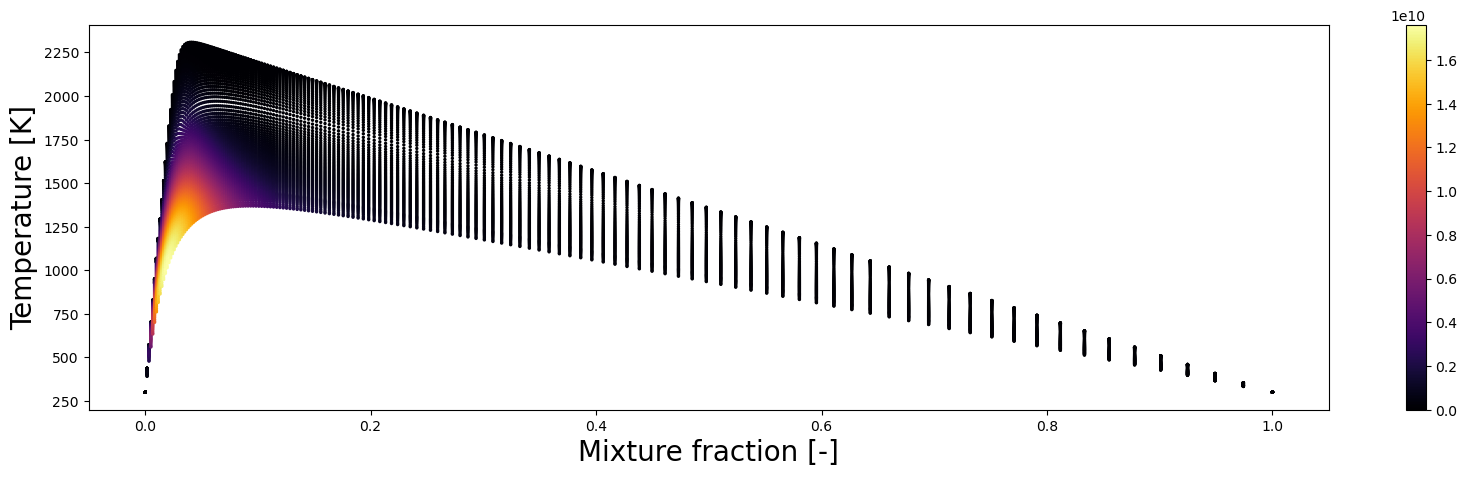

In [13]:
fig = plt.figure(figsize=(20,5))

# Create a scatter plot Temperature Vs Mixture Fraction colored by HRR
scat = plt.scatter(mixture_fraction, X[:,0], s=2, c=heat_release_rate, cmap=plt.get_cmap('inferno'))

plt.xlabel('Mixture fraction [-]', fontsize=20)
plt.ylabel('Temperature [K]', fontsize=20)
plt.colorbar(scat);

From the plot above, you see that there is one localized region, where the heat release rate is the highest. Outside of that region, it is zero or close to zero, meaning that combustion is not occuring.

Now, perform K-Means clustering if the heat release rate into 4 clusters. Note, that since we now cluster based on a single variable (one vector), it doesn't matter if we scale the vector or not.

In [14]:
# Complete the K-Means clustering steps:

kmeans_HRR     = KMeans(n_clusters=4, init='random', n_init='auto', random_state=400).fit(heat_release_rate)
idx_kmeans_HRR = kmeans_HRR.labels_

Visualize the result of clustering in the mixture fraction and temperature space:

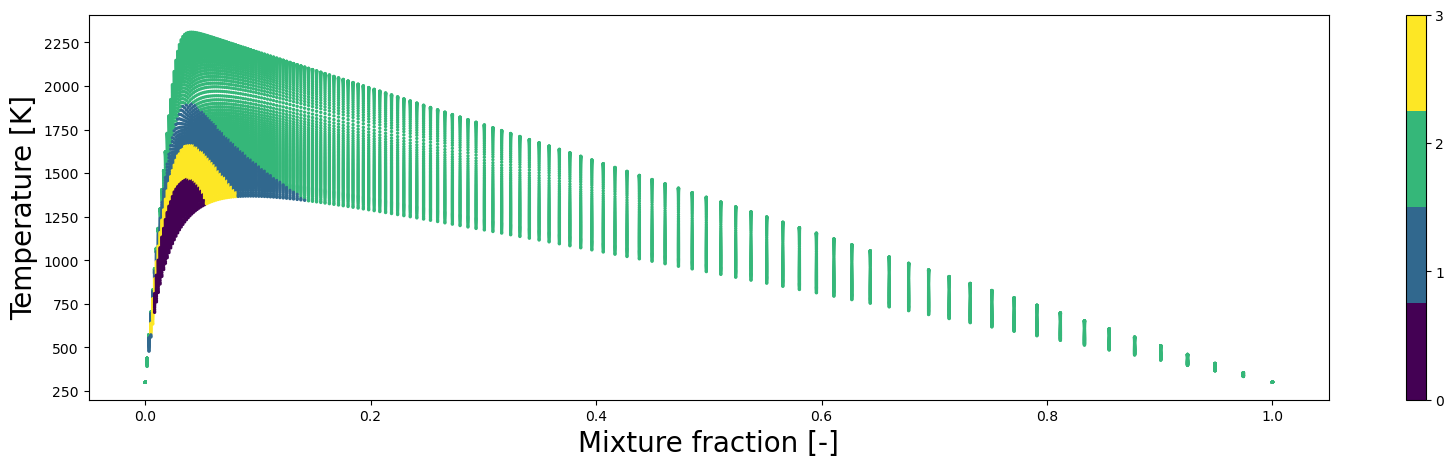

In [15]:
fig = plt.figure(figsize=(20,5))

# Create a scatter plot of the clustering solution
scat = plt.scatter(mixture_fraction, X[:,0], s=2,  c=idx_kmeans_HRR, cmap=plt.get_cmap('viridis', 4))


plt.xlabel('Mixture fraction [-]', fontsize=20)
plt.ylabel('Temperature [K]', fontsize=20)
plt.colorbar(scat, ticks=[0,1,2,3]);

What do you observe? Can you relate the clusters to different values of the heat release rate variable from the plot you generated earlier?

***

## Clustering the dataset with VQPCA

Below, we are going to also find clustering solution with VQPCA and compare it with the K-Means clustering obtained before.

We are going to use the VQPCA implementation from the [OpenMORe package](https://github.com/burn-research/OpenMORe).

We import the OpenMORe package and fill in the settings, where you can for instance set how the dataset should be centered and scaled, how many clusters, $k$, you want to create and how many eigenvectors (PCs), $q$, should be used in the cluster reconstruction at each iteration.

In [16]:
import OpenMORe.clustering as clustering

In [52]:
clustering_settings = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #set the initialization method (random, observations, kmeans, pkcia, uniform)
    "initialization_method"     : "uniform",

    #set the number of clusters and PCs in each cluster
    "number_of_clusters"        : 4,
    "number_of_eigenvectors"    : 2,

    #enable additional options:
    "correction_factor"         : "off",    # --> enable eventual corrective coefficients for the LPCA algorithm:
                                            #     'off', 'c_range', 'uncorrelation', 'local_variance', 'phc_multi', 'local_skewness' are available

    "classify"                  : False,    # --> call the method to classify a new matrix Y on the basis of the lpca clustering
    "write_on_txt"              : False,     # --> write the idx vector containing the label for each observation
    "evaluate_clustering"       : False,     # --> enable the calculation of indeces to evaluate the goodness of the clustering

    #improve the clustering solution via kNN
    "kNN_post"                  : False,     # activate the kNN algorithm once the convergence is achieved
    "neighbors_number"          : 2,       # set the number of neighbors that has to be taken into account
}

Perform VQPCA clustering of the centered and scaled dataset $\mathbf{X}$ into 4 clusters:

In [53]:
# Complete the VQPCA clustering steps:

VQPCA_X = clustering.lpca(X, clustering_settings)
idx_VQPCA_X = VQPCA_X.fit()

Preprocessing training matrix..
Fitting Local PCA model...
- Iteration number: 1
	Reconstruction error: 0.5028004018641729
	Reconstruction error variance: 0.9888607811219317
- Iteration number: 2
	Reconstruction error: 0.24055405954299164
	Reconstruction error variance: 1.090176332169995
- Iteration number: 3
	Reconstruction error: 0.20489360441466756
	Reconstruction error variance: 0.17404376886334508
- Iteration number: 4
	Reconstruction error: 0.18762906279852656
	Reconstruction error variance: 0.09201421868572353
- Iteration number: 5
	Reconstruction error: 0.17642094741207082
	Reconstruction error variance: 0.06353052486605604
- Iteration number: 6
	Reconstruction error: 0.16797911599553925
	Reconstruction error variance: 0.050255243733725384
- Iteration number: 7
	Reconstruction error: 0.16085004090994506
	Reconstruction error variance: 0.04432125130503085
- Iteration number: 8
	Reconstruction error: 0.15415685273841234
	Reconstruction error variance: 0.04341803852787738
- Iterat

Visualize the result of clustering in the mixture fraction and temperature space:

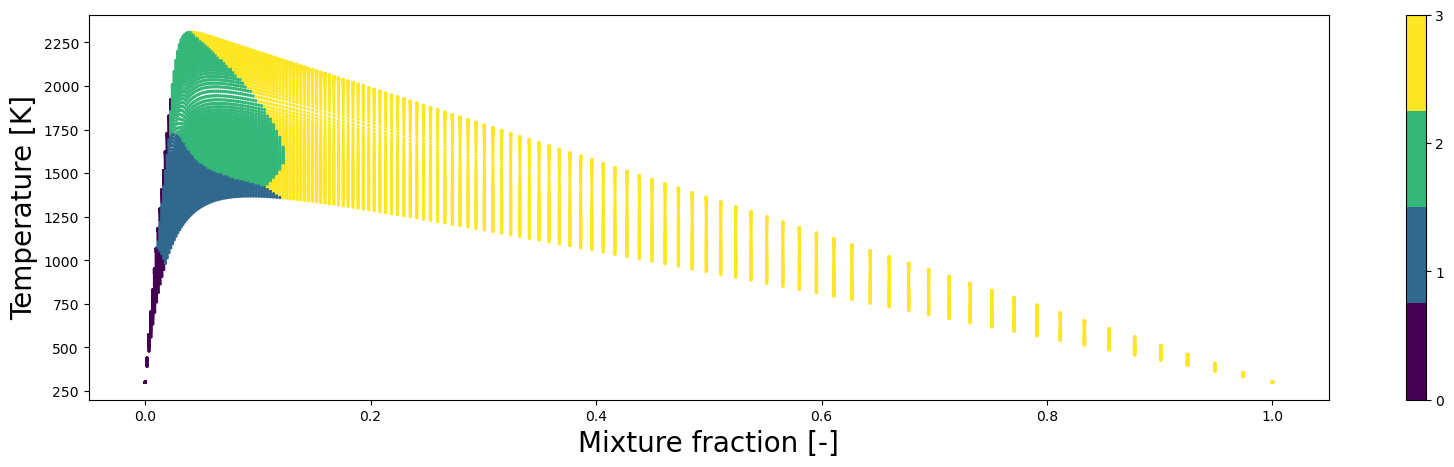

In [54]:
fig = plt.figure(figsize=(20,5))

# Create a scatter plot of the clustering solution
k=clustering_settings["number_of_clusters"]
scat = plt.scatter(mixture_fraction, X[:,0], s=2,  c=idx_VQPCA_X, cmap=plt.get_cmap('viridis', k))

plt.xlabel('Mixture fraction [-]', fontsize=20)
plt.ylabel('Temperature [K]', fontsize=20)
plt.colorbar(scat, ticks=np.arange(k));

Go back to the `clustering_settings` dictionary and play with changing the number of clusters and the number of eigenvectors.

Are the differences in clustering solution subtle or significant?

### Reading and interpretating the results

We have performed 3 different clusterings and we plot the solution on the space T-$\phi$ (Temperature - mixture fraction).

    1) KMeans on X, where X=[T, H, H2, ...]
    2) KMeans on the heat realeased rate (HRR)
    3) VQPCA  on X
    
1) Clustering number 1 differenciate 4 clusters based on the mixture fraction, $\phi$. This is importance to notice as the mixture fraction is not a given input. It is the ratio fuel/oxidizer. Therefore, based on the Temperature and species concentration, KMeans finds 4 different group of data that can be divided as:

  - Very low  $\phi$: very lean mixture, meaning that the mixture is mainly oxidizer
  - Very high $\phi$: very rich mixture, meaning that the mixture is mainly fuel
  - Two intermidate positions
 
2) Clustering number 2 differenciate 4 clusters based on HRR. The input is the HRR vector, therefore, no preproccesing was needed and the 4 clusters represents:

  - Very low  HRR
  - Low HRR
  - High HRR
  - Very high HRR
    
3) Clustering number 3. We can compare 4 clusters - 1 PC, 4 clusters - 2 PC etc ... This solution represents a more complex clustering that can not related just with one variable.

  - 4 clusters - 1PC : it identifies very low and very high $\phi$ and differenciate reaction regions on the flow
  - 4 clusters - 2PC : same principle, but different reaction regions are found. They present similarities with the HRR.
  - 5 clusters - 2PC : similar to (4 clusters - 2PC) where cluster 1 and 2 are now divided to be 1,2 and 3
  
    Changing number of cluster (k) and principal components (q) will change always the solution. A higher number of both will lead to a better reconstruction of the solution. However they have differences, k is the number of clusters, while q is related to the dimensionality of low-dimensional manifold
    
 
